In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from extraction_bam import *

In [3]:
gain=3.853           # gain [e-/ADU]
readnoise=8.365785291814616 # readout noise [e-]
bias=2576            # bias [ADU]

# Data Acquisition

In [29]:
#obsfiles=['../../datasets/gbins/bam/2017-07-02/BamObservation_000-000-{:03d}.gbin'.format(n) for n in range(19,50)]
obsfiles=['../../datasets/gbins/bam/2017-07-02/BamObs_{}.gbin'.format(n) for n in range(0,13)]
#obsfiles=['../../datasets/gbins/bam/2017-07-03/BamObservation_000-000-{:03d}.gbin'.format(n) for n in range(0,32)]

"""
import os
#prefix = '../../datasets/gbins/bam/2017-07-EVT/'
#prefix = '../../datasets/gbins/bam/2014-09-EVT/'
#prefix = '../../datasets/gbins/bam/2014-08-16/'
#prefix = '../../datasets/gbins/bam/2017-09-Precursor/'
prefix = '../../datasets/gbins/bam/2017-09-Tail/'

obsfiles = [prefix+file for file in os.listdir(prefix) if ".gbin" in file]
# sort them
import re as regex
obsfiles.sort(key = lambda path: int(regex.search("(?<=BamObs_)[0-9]+",path).group(0)))
"""

#obsfiles=[prefix+'BamObs_{}.gbin'.format(n) for n in range(90,150)]

#obsfiles=['../../datasets/gbins/bam/2017-09-11/BamObservation_000-000-{:03d}.gbin'.format(n) for n in range(0,20)]
#obsfiles = [obsfiles[11]] # flare starts at the end of 8
#obsfiles = obsfiles[8:11]

#nobs = 512 # how many obs we want to do - although this is an upper limit (chosen as max nr. of extensions for fits)
nobs = 1e6 # we can just write multiple files
i_obs = 0

In [30]:
len(obsfiles)

13

In [31]:
i_obs = 0
i_file = 0

# make two boxcars
boxrad = 3

boxcar0 = BoxCar(boxrad=boxrad, fov=1)
boxcar1 = BoxCar(boxrad=boxrad, fov=2)

# fill them

# open the reader
reader = gbin_reader.GbinReader(obsfiles[i_file])

# record acquisition times

# fill the first few elements
while True:
    (pattern, fov, acqTime) = bam_read_obs(reader, bias, gain)
    if fov == None:
        break  # should raise an error here - this should never happen
    if fov==0 and boxcar0.nfilled < boxcar0.npatterns:
        boxcar0.update(pattern, acqTime)
        boxcar0.nfilled+=1
    elif fov==1 and boxcar1.nfilled < boxcar1.npatterns:
        boxcar1.update(pattern, acqTime)
        boxcar1.nfilled+=1

    i_obs += 1
    #print(i_obs)
    if (boxcar0.nfilled >= boxcar0.npatterns and boxcar1.nfilled >= boxcar1.npatterns) or (i_obs >= nobs):
        # in the second case, we may want to give some alarm
        break

# set the i_sig
boxcar0.i_sig = boxcar0.boxrad
boxcar1.i_sig = boxcar1.boxrad

In [32]:
# let's test the execution time of this part - it takes the most time
import time
tstart = time.time()


# extract the cosmics
out0 = []
out1 = []

while ((i_obs < nobs) and i_file < len(obsfiles)):
    # extract cosmics from fov 0 and 1 and save them
    
    ### FOV 1
    sig, err = boxcar0.get_signal(readnoise)
    #output = bam_cosmics(sig, err, 4, 0.5, N_mask, gain)
    #output = bam_cosmics(sig, err, 5, 0.35, N_mask, gain)  # parameters from validation
    output = bam_cosmics_mended(sig, err, 5, 0.4, gain) # additional tweaking to remove spurious background (always try to be above 2 sigma)
    # update the keys
    output.acqTime = boxcar0.acqTimes[boxcar0.i_sig]
    output.row=1  # is this always true?
    output.fov=boxcar0.fov
    output.gain=gain
    out0.append(output)
    
    ### FOV 2
    sig, err = boxcar1.get_signal(readnoise)
    #output = bam_cosmics(sig, err, 4, 0.5, N_mask, gain)
    #output = bam_cosmics(sig, err, 5, 0.35, N_mask, gain)  # parameters from validation
    output = bam_cosmics_mended(sig, err, 5, 0.4, gain) # additional tweaking to remove spurious background (always try to be above 2 sigma)
    # update the headers
    output.acqTime = boxcar1.acqTimes[boxcar1.i_sig]
    output.row=1  # is this always true?
    output.fov=boxcar1.fov
    output.gain=gain
    out1.append(output)
    
    # update the boxcars
    for ii in range(2):
        (pattern, fov, acqTime) = bam_read_obs(reader, bias, gain)
        if fov == None:
            # this file is finished
            print(i_file)
            reader.close()
            # get the next or stop
            i_file +=1
            if i_file >= len(obsfiles):
                break  # we're finished
            else:
                reader = gbin_reader.GbinReader(obsfiles[i_file]) # start with next file
        if fov==0:
            boxcar0.update(pattern, acqTime)
        elif fov==1:
            boxcar1.update(pattern, acqTime)
        i_obs += 1
        #print(i_obs)
        
reader.close()
tend = time.time()
print("Elapsed time:", tend - tstart)

0
1
2
3
4
5
6
7
8
9
10
11
12
Elapsed time: 587.603301525116


# Saving the data

In [76]:
from astropy.io import fits

In [30]:
timingbeg = time.time()


# since we have enough to fill multiple files now, we need to be smarter
# put all this into one folder
outroot = "output/2017-07-03_cross_erosion/"

# save the data piece by piece - 500 trackobs per file, separated by fov
perfile = 500
outs = [out0, out1]
for ifov in range(2):
    for ifile in range(np.ceil(len(outs[ifov])/perfile).astype("int")):
        tstart = outs[ifov][perfile*ifile].acqTime.astype(int)
        filename = "BAM-OBS{}_OBMT_START_{}.fits".format(ifov+1,tstart)
        write_Obslist(outs[ifov][perfile*ifile:perfile*(ifile+1)], outroot+filename)
    print("Finished FOV",ifov+1)
        

timingend = time.time()
print("Elapsed time:", timingend - timingbeg)

Finished FOV 1
Finished FOV 2
Elapsed time: 374.2658476829529


# Reading data

In [18]:
import time
tstart = time.time()

inlist = read_Obslist_fits('output_test.fits')

tend = time.time()
print("Elapsed time:", tend - tstart)

Elapsed time: 1.7078661918640137


# Some diagnostics

In [13]:
print(len(out0[0].data))
#print(out0[0][9])

103


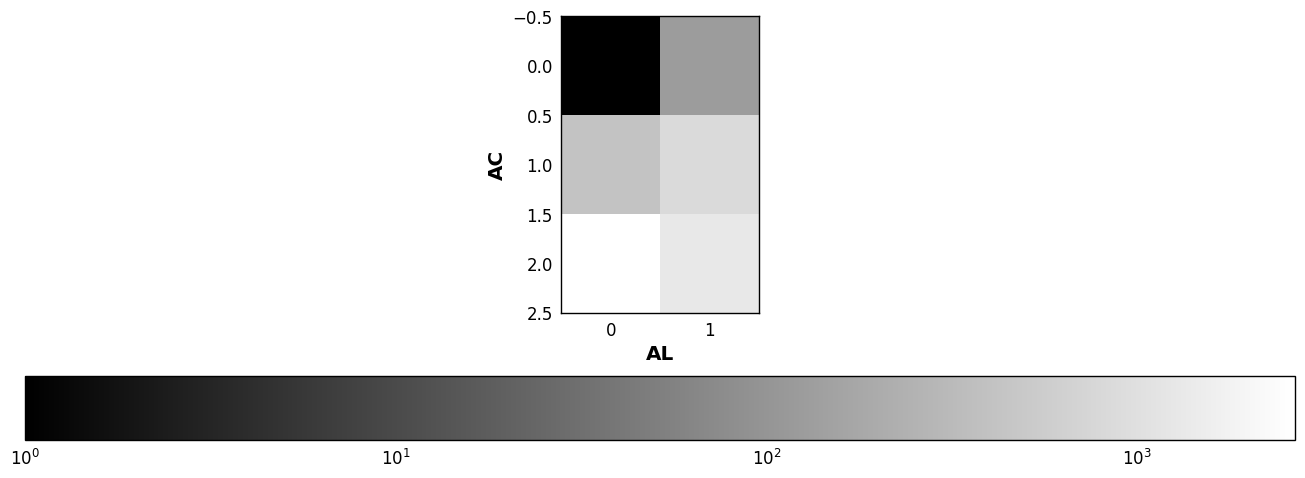

In [14]:
i_obs = 0
i_track = 9

track = out0[0].data[i_track]["TRACK"]
dims = (out0[0].data[i_track]["DIM_AL"],out0[0].data[i_track]["DIM_AC"])
image = np.rot90(np.reshape(track, dims))

plt.xlabel('AL')
plt.ylabel('AC')
#plt.imshow(image, cmap='gray',vmin=4, vmax=4.1)
plt.imshow(image+1, cmap='gray',vmin=1,norm=LogNorm())
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

In [33]:
# This should be quite a lot of energies, so do a histogram

E0 = []
E1 = []

# also for lengths, why not
AL0 = []
AL1 = []
AC0 = []
AC1 = []

for ii in range(len(out0)):
    E0 += list(out0[ii].data["TRACK_EN"])
    AL0 += list(out0[ii].data["DIM_AL"]-1)
    AC0 += list(out0[ii].data["DIM_AC"]-1)
    E1 += list(out1[ii].data["TRACK_EN"])
    AL1 += list(out1[ii].data["DIM_AL"]-1)
    AC1 += list(out1[ii].data["DIM_AC"]-1)

E0 = np.array(E0)
E1 = np.array(E1)
AL0 = np.array(AL0)
AC0 = np.array(AC0)
AL1 = np.array(AL1)
AC1 = np.array(AC1)

        
# number of cosmics
print("FOV 0:", len(E0), "cosmics")
print("FOV 1:", len(E1), "cosmics")

FOV 0: 128053 cosmics
FOV 1: 126953 cosmics


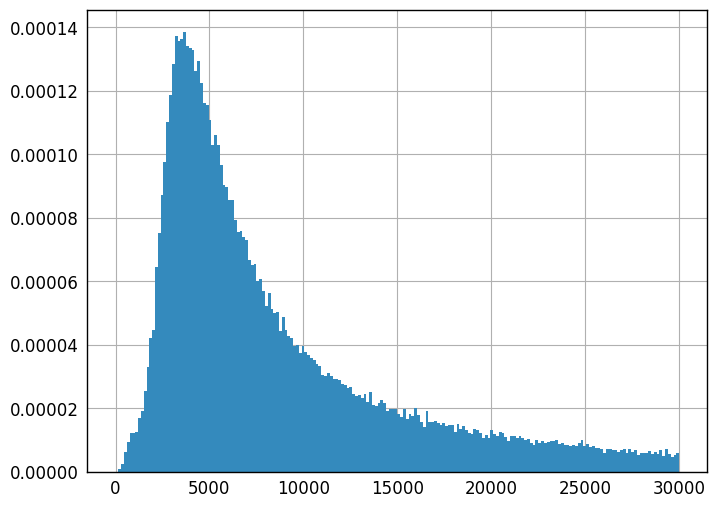

In [34]:
hist0 = plt.hist(E0, 200, log=False ,range=(0,30000), normed=True)

#plt.xlabel("Deposited Energy [electrons]")
#plt.ylabel("Occurrence")

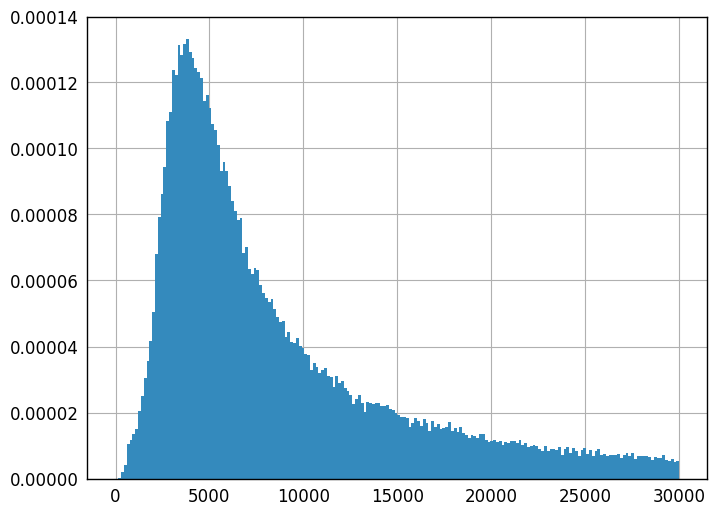

In [35]:
hist1 = plt.hist(E1, 200, log=False ,range=(0,30000), normed=True)

In [36]:
# Let's try the angles
# For now without how it faces

lx = AL0*10  # mum
ly = AC0*120 # mum
lengths = np.sqrt(lx*lx + ly*ly)

theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 5000  # 90
theta[ly==0] = 5000  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

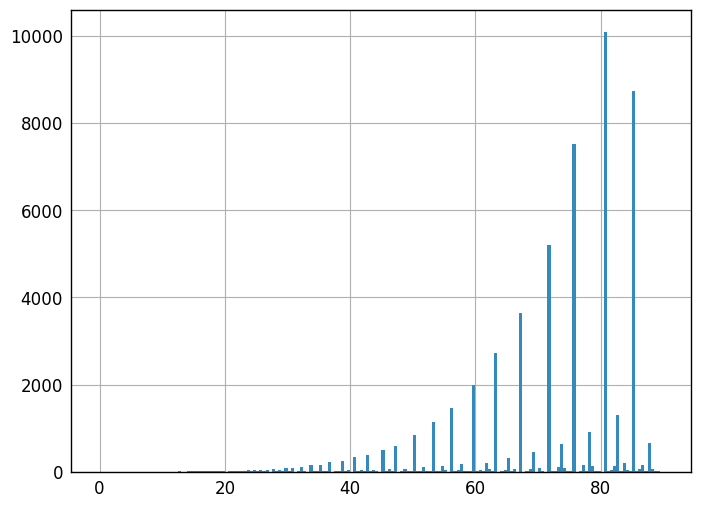

In [37]:
thist = plt.hist(theta,180,range=(0,90))

-> VERY biased

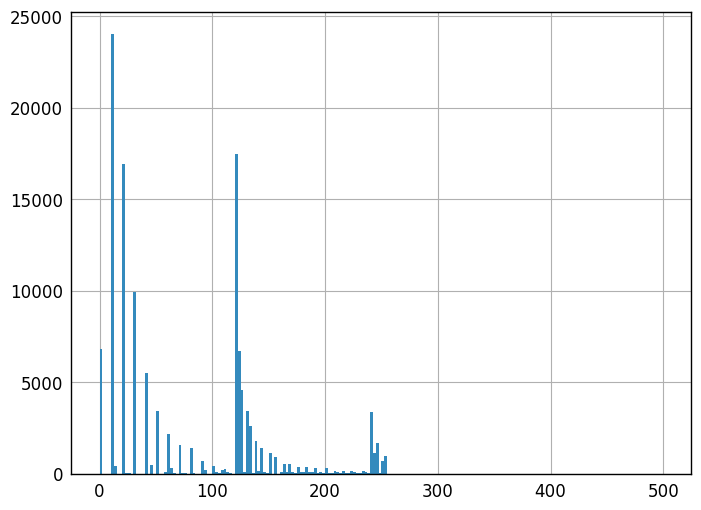

In [38]:
lengths = np.sqrt(lx*lx + ly*ly)

thist = plt.hist(lengths,200,range=(0,500),log=False)

One sees individual contributions from the length in AC and AL.

Fun estimation: Let's see if dE/dx gives us anything

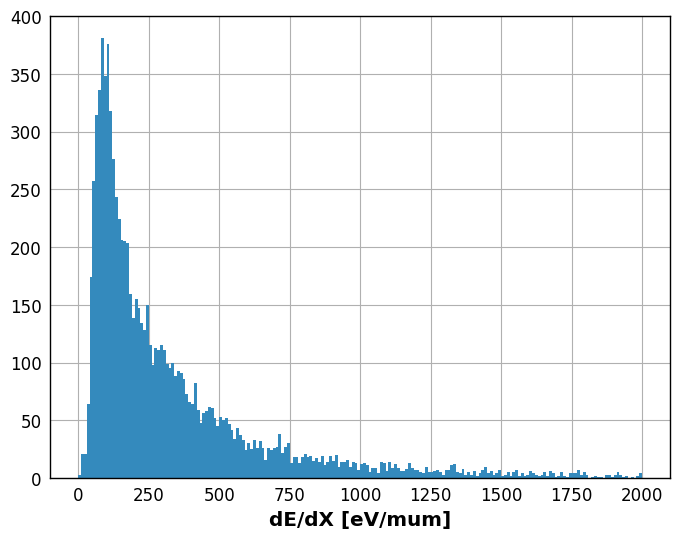

In [39]:
dEdx = E0/np.sqrt(lengths**2+40**2) # assuming our length measurement is good and we excite the whole detector

dEdx *= 3.6   # energy (eV) per electron/hole pair

thist = plt.hist(dEdx[lengths>200],200,log=False,range=(0,2000))
plt.xlabel("dE/dX [eV/mum]")

I have to say, this looks remarkably like a landau distribution.

(It should not be, since we have multiple particle species/energies)

-> For normal obs: maximum at about 250 eV/mum = 2.5 MeV/cm = (for silicon) about 1 MeV cm2 / g

-> Minimum Ionizing Particle? That's about 1 GeV!

-> For Flare: also very Landau, max at about 500 eV/mum = 5 MeV/cm = 2 MeV cm2 / g

-> Either higher or lower energies - hard to say, since close to MIP

(Note: This is still all very suspect)

However, it's actually consistent with the paper by Jos using the Creme-background of the GCR (1 GeV) and Spenvis solar protons (10-10^2 MeV)...

In [40]:
acqTimes = []

for ii in range(len(out0)):
    acqTimes.append(out0[ii].acqTime)
    
acqTimes = np.array(acqTimes)
# both fov have the same acqTime

First OBMT: 115987422738124704


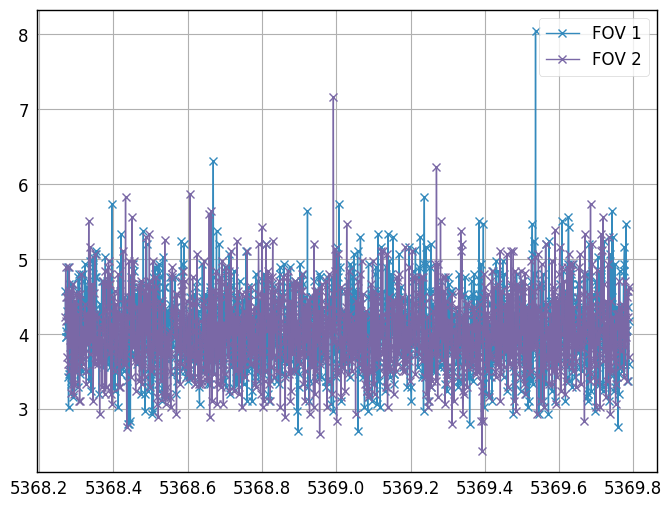

In [41]:
# fluxes
flux0 = np.array([obs.calculate_flux()[0] for obs in out0])
flux1 = np.array([obs.calculate_flux()[0] for obs in out1])

plt.plot((acqTimes)/1e9/3600/6,flux0,marker='x',label="FOV 1")
plt.plot((acqTimes)/1e9/3600/6,flux1,marker='x',label="FOV 2")
plt.legend(loc="best")

print("First OBMT:", int(acqTimes[-1]))
#plt.xlim(5364.63,5364.64)
#plt.gcf().set_size_inches(10,10)

In [42]:
np.median(flux0)

4.0470172682224286

In [43]:
np.median(flux1)

4.0025445509892155

In [44]:
# for fun - make a cosmic ray image from a TrackObs

obs = out1[-1]

obsimg = np.ones((obs.srcAL,obs.srcAC))

for ii in range(len(obs.data)):
    track = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
    start_AL = obs.data[ii]["LOC_AL"]
    stop_AL = obs.data[ii]["LOC_AL"] + obs.data[ii]["DIM_AL"]
    start_AC = obs.data[ii]["LOC_AC"]
    stop_AC = obs.data[ii]["LOC_AC"] + obs.data[ii]["DIM_AC"]
    obsimg[start_AL:stop_AL,start_AC:stop_AC] += track*gain

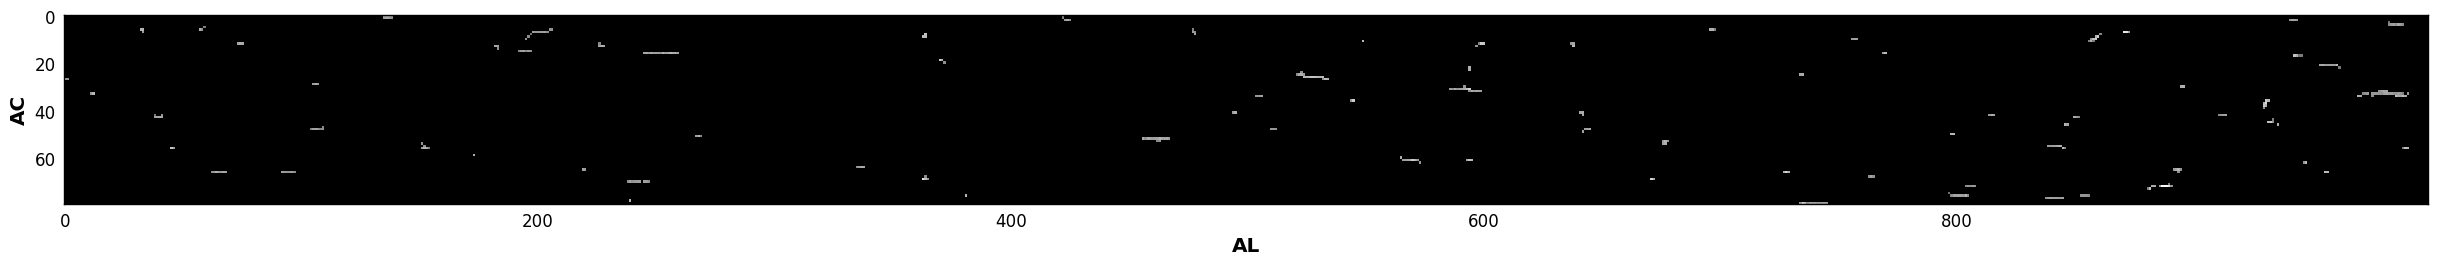

In [45]:
im=np.rot90(obsimg,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='gray',norm=LogNorm())
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

# Identification of a super-high energy cosmic (which actually overflows)

The source of this one is '../../datasets/gbins/bam/09-2017/BamObservation_000-000-011.gbin', and out0[-2] there.

In [23]:
# I want to see if there are any negative cosmics, and if so, what they look like

longest = np.argmax(np.sqrt(obs.data["DIM_AL"]**2+obs.data["DIM_AC"]**2))

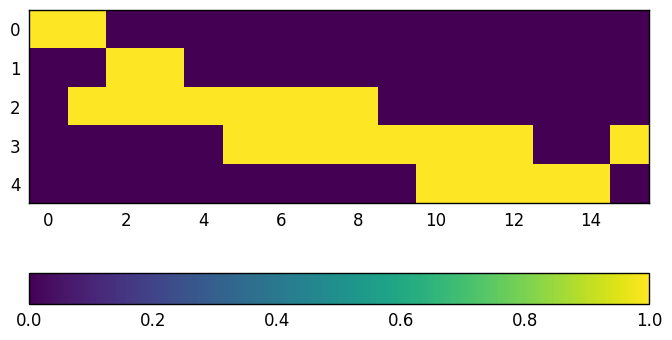

In [24]:
ii = longest
im = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
plt.imshow(np.rot90(im,1),vmax=1)
plt.grid(False)
plt.colorbar(orientation="horizontal")

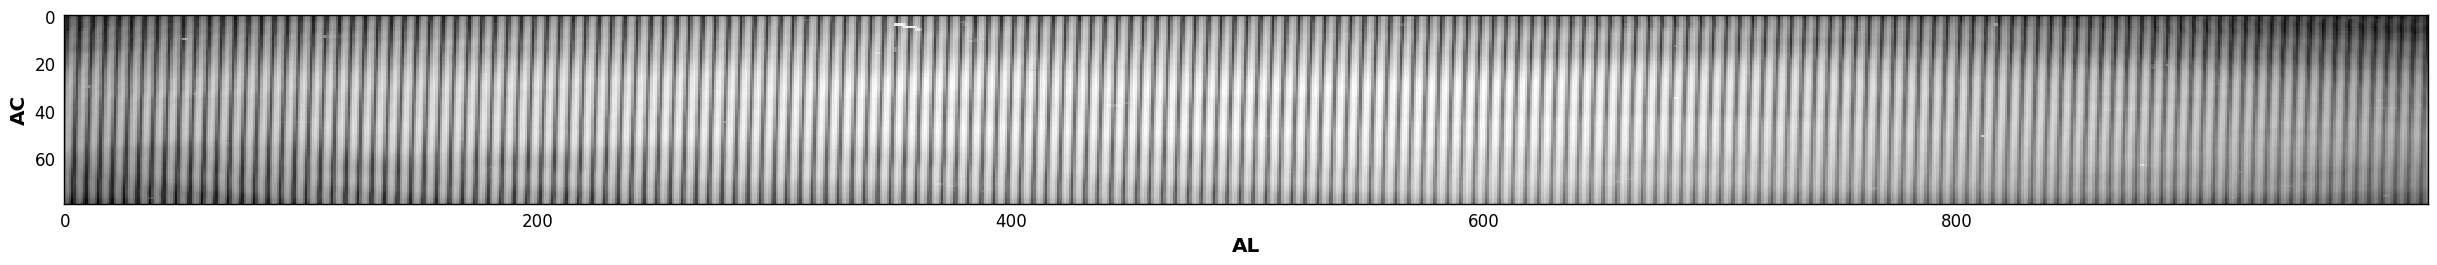

In [25]:
im = np.rot90(boxcar0.patterns[6],1)
plt.imshow(im, cmap='gray',norm=LogNorm())
plt.xlabel('AL')
plt.ylabel('AC')
plt.grid(False)
plt.gcf().set_size_inches(30.5, 5.5)


In [128]:
# okay, with some fakery, we can reconstruct this
boxcar0.i_sig=6
sig, err, N_mask = boxcar0.get_signal(readnoise)

print(N_mask)
print(bias)


30
2576


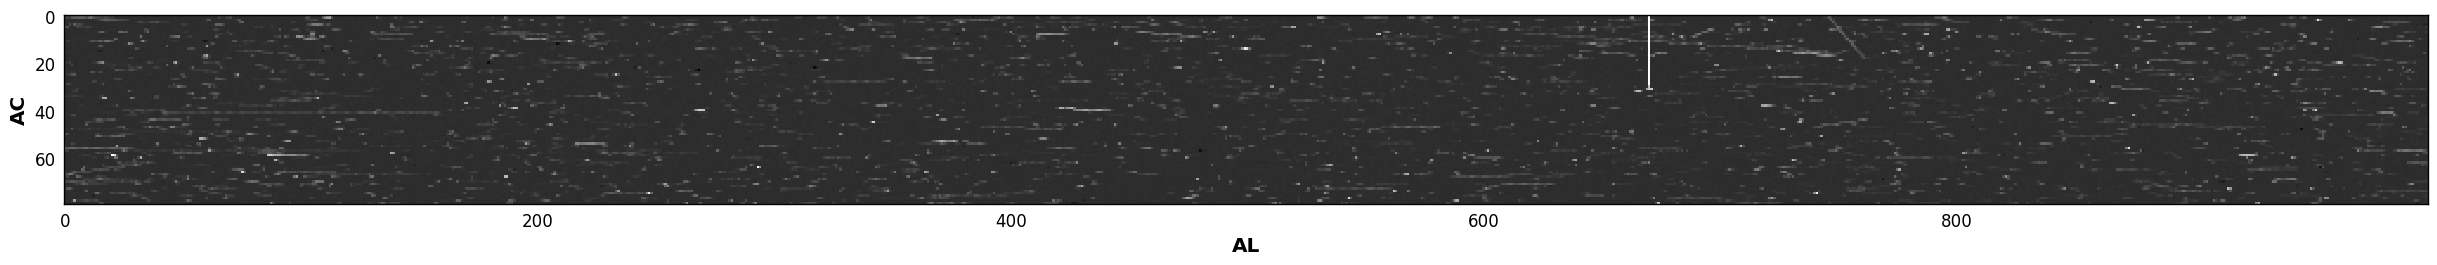

In [129]:
im = np.rot90(sig/err,1)
plt.imshow(im, cmap='gray')#,norm=LogNorm())
plt.xlabel('AL')
plt.ylabel('AC')
plt.grid(False)
plt.gcf().set_size_inches(30.5, 5.5)


In [150]:
signal = sig
err_mean = err
threshold = 4
threshfrac=0.5
import astroscrappy
import scipy.ndimage as ndimage

(xmax,ymax) = signal.shape  # for saving, later
# construct mask from signal/error
SN = signal/err_mean
mask = np.zeros(signal.shape)
mask[SN > threshold] = 1

# neighbours
mask = mask.astype('bool')

mask = astroscrappy.dilate3(mask)
mask = np.logical_and(SN > threshold, mask)

# dilation - do this a few times
for ii in range(10):
    newmask = astroscrappy.dilate3(mask)
    newmask = np.logical_and(SN > threshfrac*threshold, newmask)
    if (newmask==mask).all():
        break
    else:
        mask = newmask

# label cosmics
(labels, ntracks) = ndimage.measurements.label(mask, structure=(np.ones((3,3))))

# object extraction
events = ndimage.measurements.find_objects(labels)

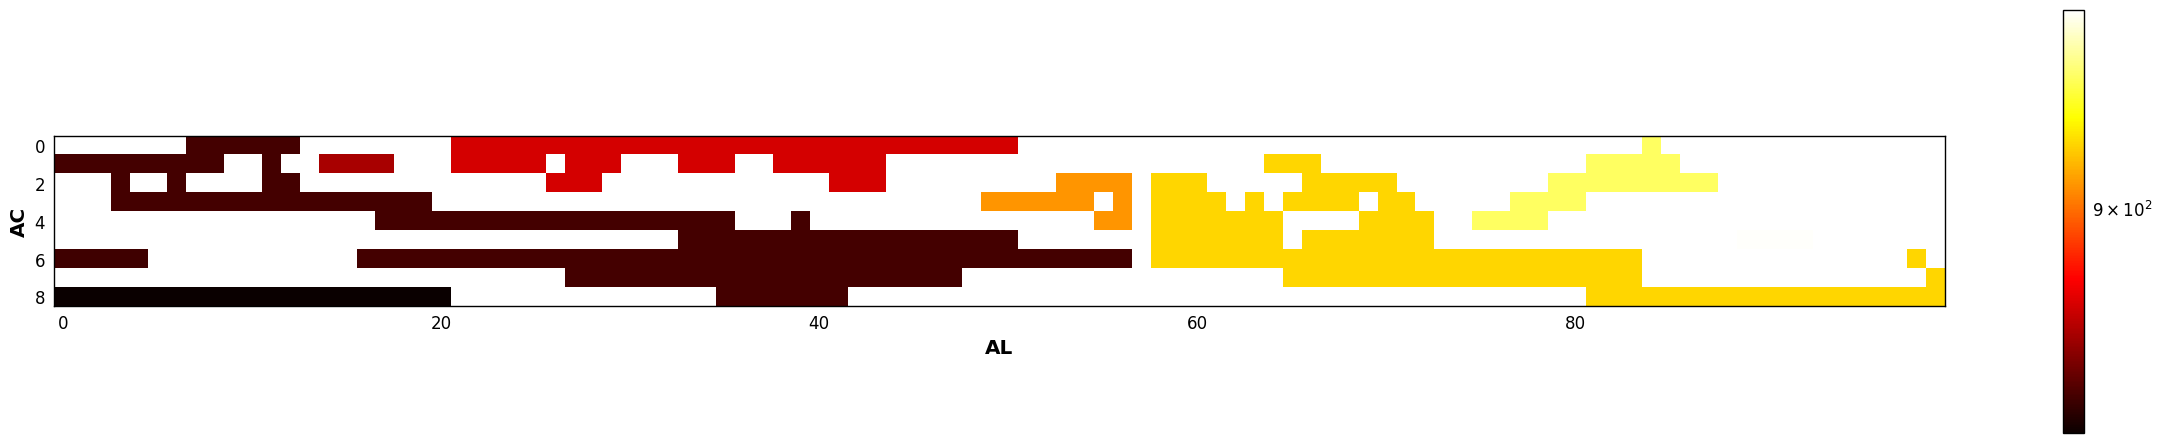

In [151]:
im = np.rot90(labels[613:100+613,66:9+66])
#im = np.rot90((signal/err_mean)[613:100+613,66:9+66])

plt.imshow(im, cmap='hot',norm=LogNorm())
plt.xlabel('AL')
plt.ylabel('AC')
plt.grid(False)
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar()

In [145]:
np.unique(labels[613:57+613,66:9+66][40,8])

array([963], dtype=int32)